## 4.Model Evaluation and Implementation

In [7]:
# Import pandas as pd
import pandas as pd
import matplotlib as mtlb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn as skl 
from sklearn import metrics
from sklearn.calibration import calibration_curve
import xgboost as xgb

In [2]:
# Read in the csv file
clean_loan_data = pd.read_csv('clean_loan_data.csv')

Creating and training LogisticRegression and XGBoost models

In [3]:
# Create two data sets for numeric and non-numeric data
cred_num = clean_loan_data.select_dtypes(exclude=['object'])
cred_str = clean_loan_data.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# Union the one-hot encoded columns to the numeric ones
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

In [4]:
# Create the X and y data sets
X = cr_loan_prep.drop(['loan_status'], axis=1)
y = cr_loan_prep[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

In [5]:
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)

In [13]:
# Train a model on the X data
clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

# Predict the loan_status using each model
gbt_preds = clf_gbt.predict(X_test)
gbt_preds_df=pd.DataFrame(clf_gbt.predict_proba(X_test), columns = ['prob_not_default','prob_default'])

In [14]:
# Train the logistic regression model on the training data
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
preds = clf_logistic.predict_proba(X_test)

In [15]:
# Create a dataframe for the probabilities of default
lr_preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
lr_preds_df['loan_status'] = lr_preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

In [16]:
# Print the classification report of the first model
target_names = ['Non-Default', 'Default']
print(metrics.classification_report(y_test, lr_preds_df['loan_status'], target_names=target_names))

# Print the classification report of the second model
print(metrics.classification_report(y_test, gbt_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.86      0.92      0.89      9198
     Default       0.62      0.46      0.53      2586

    accuracy                           0.82     11784
   macro avg       0.74      0.69      0.71     11784
weighted avg       0.81      0.82      0.81     11784

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9198
     Default       0.94      0.74      0.83      2586

    accuracy                           0.93     11784
   macro avg       0.94      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784



In [17]:
# Print and compare the AUC scores of the old and new models
print(metrics.roc_auc_score(y_test, lr_preds_df['prob_default']))
print(metrics.roc_auc_score(y_test, gbt_preds_df['prob_default']))

0.7643248801355148
0.9470307526754782


1. Comparing model reports

You've used logistic regression models and gradient boosted trees. It's time to compare these two to see which model will be used to make the final predictions.

One of the easiest first steps for comparing different models' ability to predict the probability of default is to look at their metrics from the classification_report(). With this, you can see many different scoring metrics side-by-side for each model. Because the data and models are normally unbalanced with few defaults, focus on the metrics for defaults for now.

In [18]:
# Print and compare the AUC scores of the old and new models
print(metrics.precision_recall_fscore_support(y_test, lr_preds_df['loan_status'])[2])
print(metrics.precision_recall_fscore_support(y_test, gbt_preds)[2])


[0.88940189 0.53238687]
[0.95833333 0.82855903]


2. Comparing with ROCs

You should use ROC charts and AUC scores to compare the two models. Sometimes, visuals can really help you and potential business users understand the differences between the various models under consideration.

With the graph in mind, you will be more equipped to make a decision. The lift is how far the curve is from the random prediction. The AUC is the area between the curve and the random prediction. The model with more lift, and a higher AUC, is the one that's better at making predictions accurately.

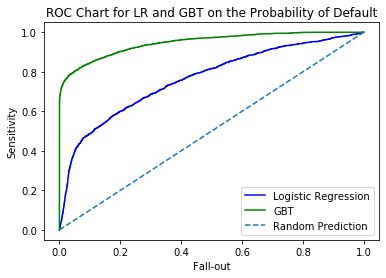

In [19]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = metrics.roc_curve(y_test, lr_preds_df['prob_default'])
fallout_gbt, sensitivity_gbt, thresholds_gbt = metrics.roc_curve(y_test, gbt_preds_df['prob_default'])

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

3. Calibration curves

You now know that the gradient boosted tree clf_gbt has the best overall performance. You need to check the calibration of the two models to see how stable the default prediction performance is across probabilities. You can use a chart of each model's calibration to check this by calling the calibration_curve() function.

Calibration curves can require many lines of code in python, so you will go through each step slowly to add the different components.

In [20]:
frac_of_pos_lr, mean_pred_val_lr = calibration_curve(y_test, lr_preds_df['prob_default'],n_bins=5)
frac_of_pos_gbt, mean_pred_val_gbt = calibration_curve(y_test, gbt_preds_df['prob_default'],n_bins=5)
print(calibration_curve(y_test, lr_preds_df['loan_status'],n_bins=5))


(array([0.14053944, 0.62434964]), array([0., 1.]))


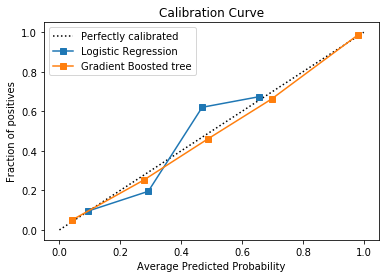

In [21]:
# Add the calibration curve for the gradient boosted tree
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,
         's-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

4. Acceptance rates

Setting an acceptance rate and calculating the threshold for that rate can be used to set the percentage of new loans you want to accept. For this exercise, assume the test data is a fresh batch of new loans. You will need to use the quantile() function from numpy to calculate the threshold.

The threshold should be used to assign new loan_status values. Does the number of defaults and non-defaults in the data change?

In [23]:
# Check the statistics of the probabilities of default
print(gbt_preds_df['prob_default'].describe())

# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(gbt_preds_df['prob_default'], 0.85)

# Apply acceptance rate threshold
gbt_preds_df['pred_loan_status'] = gbt_preds_df['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(gbt_preds_df['pred_loan_status'].count())

count    11784.000000
mean         0.214355
std          0.345175
min          0.000001
25%          0.009491
50%          0.042282
75%          0.188474
max          0.999996
Name: prob_default, dtype: float64
11784


You know how quantile() works to compute a threshold, and you've seen an example of what it does to split the loans into accepted and rejected. What does this threshold look like for the test set, and how can you visualize it?

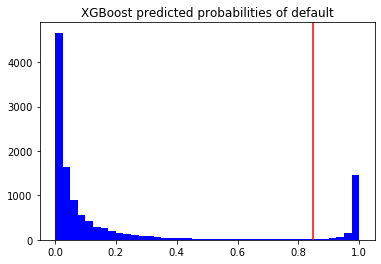

In [24]:
# Plot the predicted probabilities of default
plt.hist(gbt_preds_df['prob_default'], color = 'blue', bins = 40)

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold_85, color = 'red')
plt.title('XGBoost predicted probabilities of default')
plt.show()

5. Bad rates

With acceptance rate in mind, you can now analyze the bad rate within the accepted loans. This way you will be able to see the percentage of defaults that have been accepted.

Think about the impact of the acceptance rate and bad rate. We set an acceptance rate to have fewer defaults in the portfolio because defaults are more costly. Will the bad rate be less than the percentage of defaults in the test data?

In [25]:
#add column with true loan status
gbt_preds_df=pd.concat([gbt_preds_df.reset_index(drop = True),
                       y_test.reset_index(drop = True)], axis = 1)

In [26]:
#accepted loans
accepted_loans=gbt_preds_df[gbt_preds_df['pred_loan_status']==0]
bad_rate=(accepted_loans['loan_status'].sum()/accepted_loans['loan_status'].count())
print(bad_rate)

0.08306709265175719


6. Acceptance rate impact

Now, look at the loan_amnt of each loan to understand the impact on the portfolio for the acceptance rates. You can use cross tables with calculated values, like the average loan amount, of the new set of loans X_test. For this, you will multiply the number of each with an average loan_amnt value.

When printing these values, try formatting them as currency so that the numbers look more realistic. After all, credit risk is all about money. This is accomplished with the following code:

pd.options.display.float_format = '${:,.2f}'.format

In [33]:
# Print the statistics of the loan amount column
print(cr_loan_prep['loan_amnt'].describe())

# Store the average loan amount
avg_loan = np.mean(cr_loan_prep['loan_amnt'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(gbt_preds_df['loan_status'],
                 gbt_preds_df['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

count   $29,459.00
mean     $9,583.60
std      $6,314.42
min        $500.00
25%      $5,000.00
50%      $8,000.00
75%     $12,250.00
max     $35,000.00
Name: loan_amnt, dtype: float64
pred_loan_status              0              1
loan_status                                   
0                $88,015,791.00    $134,170.41
1                 $7,973,555.98 $16,809,636.04


7. Making the strategy table

Before you implement a strategy, you should first create a strategy table containing all the possible acceptance rates you wish to look at along with their associated bad rates and threshold values. This way, you can begin to see each part of your strategy and how it affects your portfolio.

Automatically calculating all of these values only requires a for loop, but requires many lines of python code. Don't worry, most of the code is already there. Remember the calculations for threshold and bad rate.

In [47]:
accept_rates = np.linspace(1,0.05,20)
thresholds=[]
bad_rates=[]
test_pred_df=gbt_preds_df
test_pred_df['avg_loan']=avg_loan
print(test_pred_df.info())
pd.options.display.float_format = '{:,.2f}'.format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11784 entries, 0 to 11783
Data columns (total 5 columns):
prob_not_default    11784 non-null float32
prob_default        11784 non-null float32
pred_loan_status    11784 non-null int64
loan_status         11784 non-null int64
avg_loan            11784 non-null float64
dtypes: float32(2), float64(1), int64(2)
memory usage: 368.3 KB
None


In [48]:
# Populate the arrays for the strategy table with a for loop
#print(test_pred_df.info())
for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(gbt_preds_df['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(thresh)
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = gbt_preds_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[gbt_preds_df['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['loan_status']) / len(accepted_loans['loan_status'])).round(3))

In [49]:
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0              1.00       1.00      0.22
1              0.95       1.00      0.18
2              0.90       0.99      0.13
3              0.85       0.85      0.08
4              0.80       0.31      0.06
5              0.75       0.19      0.05
6              0.70       0.13      0.04
7              0.65       0.09      0.03
8              0.60       0.07      0.03
9              0.55       0.05      0.02
10             0.50       0.04      0.02
11             0.45       0.03      0.02
12             0.40       0.03      0.02
13             0.35       0.02      0.01
14             0.30       0.01      0.01
15             0.25       0.01      0.01
16             0.20       0.01      0.01
17             0.15       0.00      0.00
18             0.10       0.00      0.00
19             0.05       0.00      0.00


8. Visualizing the strategy

Now you have the extended strategy table strat_df. The table is not so big that it's difficult to analyze, but visuals can help you see the overview all at once.

You should check at the distribution of each column with a box plot. If the distribution of Acceptance Rate looks the same as the Bad Rate column, that could be a problem. That means that the model's calibration is likely much worse than you thought.

You can also visualize the strategy curve with a line plot. The Acceptance Rate would be the independent variable with the Bad Rate as the dependent variable.

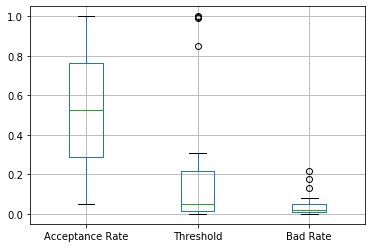

In [50]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
Acceptance Rate    20 non-null float64
Threshold          20 non-null float64
Bad Rate           20 non-null float64
dtypes: float64(3)
memory usage: 560.0 bytes
None


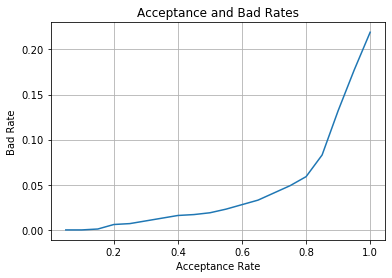

In [62]:
# Plot the strategy curve
print(strat_df.info())
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.grid()
plt.show()

9. Estimated value profiling

The strategy table, strat_df, can be used to maximize the estimated portfolio value and minimize expected loss. Extending this table and creating some plots can be very helpful to this end.

In [ ]:
# Create a line plot of estimated value
plt.plot(strat_df['Acceptance Rate'],strat_df['Estimated Value'])
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.axes().yaxis.grid()
plt.show()